Forcasting in Engineering und Management

In [76]:
# ----------------------------------------
# Forecasting in Engineering & Management
# Main Notebook: FoEM_Projekt.ipynb
# Cleaned for S&P 500 only
# ----------------------------------------

# Core packages
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Statistical tools
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pandas.tseries.offsets import BDay
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from prophet import Prophet
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler


# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Utilities
import os
import warnings
warnings.filterwarnings("ignore")
import logging
from datetime import timedelta

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [77]:
# Dynamic date range
today = dt.date.today()
years_back = 5  # Change to 1, 10, 15, etc. as needed
start_date = today - timedelta(days=365 * years_back)

# Downloading S&P 500 data
ticker = '^GSPC'
logging.info(f"Fetching S&P 500 data from {start_date} to {today}")
sp500 = yf.download(ticker, start=start_date, end=today)
sp500 = sp500[['Open', 'High', 'Low', 'Close', 'Volume']]
sp500.dropna(inplace=True)
sp500.index = pd.to_datetime(sp500.index)
logging.info(f"Downloaded {len(sp500)} rows.")

2025-05-03 16:16:53,475 - INFO - Fetching S&P 500 data from 2020-05-04 to 2025-05-03
[*********************100%***********************]  1 of 1 completed
2025-05-03 16:16:53,523 - INFO - Downloaded 1257 rows.


In [78]:
sp500.head()

Price,Open,High,Low,Close,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2020-05-04,2815.010010,2844.239990,2797.850098,2842.739990,4735930000
2020-05-05,2868.879883,2898.229980,2863.550049,2868.439941,5140290000
2020-05-06,2883.139893,2891.110107,2847.649902,2848.419922,4892570000
2020-05-07,2878.260010,2901.919922,2876.479980,2881.189941,5178790000
2020-05-08,2908.830078,2932.159912,2902.879883,2929.800049,4876030000


In [79]:
sp500.describe()

Price,Open,High,Low,Close,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
count,1257.000000,1257.000000,1257.000000,1257.000000,1.257000e+03
mean,4443.002850,4469.088147,4415.366043,4443.936939,4.357916e+09
std,769.703294,770.611314,767.916158,769.484693,9.736979e+08
min,2794.540039,2844.239990,2766.639893,2820.000000,1.639500e+09
25%,3924.520020,3958.330078,3903.649902,3931.330078,3.776100e+09
50%,4342.120117,4369.870117,4306.240234,4347.350098,4.152250e+09
75%,4899.189941,4929.310059,4881.470215,4924.970215,4.703620e+09
max,6134.500000,6147.430176,6111.149902,6144.149902,9.976520e+09


In [80]:
sp500.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1257 entries, 2020-05-04 to 2025-05-02
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Open, ^GSPC)    1257 non-null   float64
 1   (High, ^GSPC)    1257 non-null   float64
 2   (Low, ^GSPC)     1257 non-null   float64
 3   (Close, ^GSPC)   1257 non-null   float64
 4   (Volume, ^GSPC)  1257 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 58.9 KB


In this step, we apply classical decomposition to the S&P 500 closing price time series.  
We break down the series into 3 components:
- **Trend**: Long-term movement over time
- **Seasonality**: Repeating short-term cycles (e.g., yearly financial trends)
- **Residual**: Remaining noise after removing trend and seasonality

To ensure decomposition works, we:
- Reindex the data to **business day frequency** (`'B'`)
- Apply **forward-fill** to handle non-trading days (which introduce NaNs)

The decomposition assumes **additive structure** and a period of **252 trading days per year**.

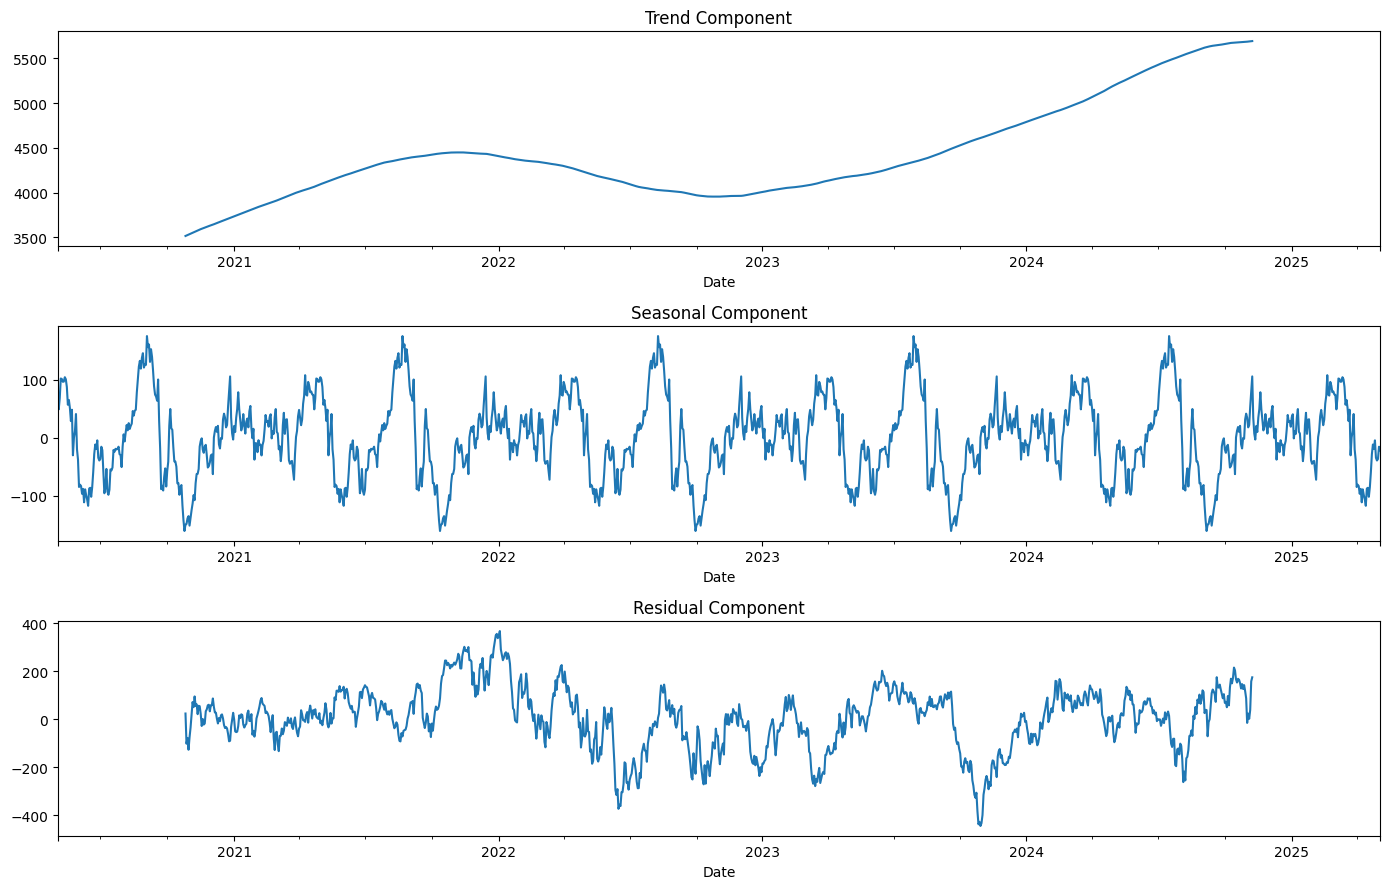

In [81]:
# Plotting the S&P 500 'Close' price

# Extract 'Close' price and align frequency
ts = sp500['Close'].copy()       # Using 'Close' prices
ts = ts.asfreq('B')              # Convert to Business Day frequency (Mon–Fri)
ts = ts.ffill()                  # Fill non-trading days with previous value

# Perform seasonal decomposition
result = seasonal_decompose(ts, model='additive', period=252)  # 252 trading days/year

# Plot trend, seasonality, and residual components
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 9))
result.trend.plot(ax=ax1, title='Trend Component')
result.seasonal.plot(ax=ax2, title='Seasonal Component')
result.resid.plot(ax=ax3, title='Residual Component')
plt.tight_layout()
plt.show()

In this step, we assess whether the S&P 500 time series is **stationary**, meaning its statistical properties (mean, variance) are constant over time.

We use two complementary methods:
- **Visual Inspection**: Plotting the rolling mean and standard deviation
- **Statistical Test**: Augmented Dickey-Fuller (ADF) test

A stationary time series is often required before applying models like **ARIMA**.  
If the ADF p-value > 0.05, we fail to reject the null hypothesis and conclude the series is **non-stationary**.

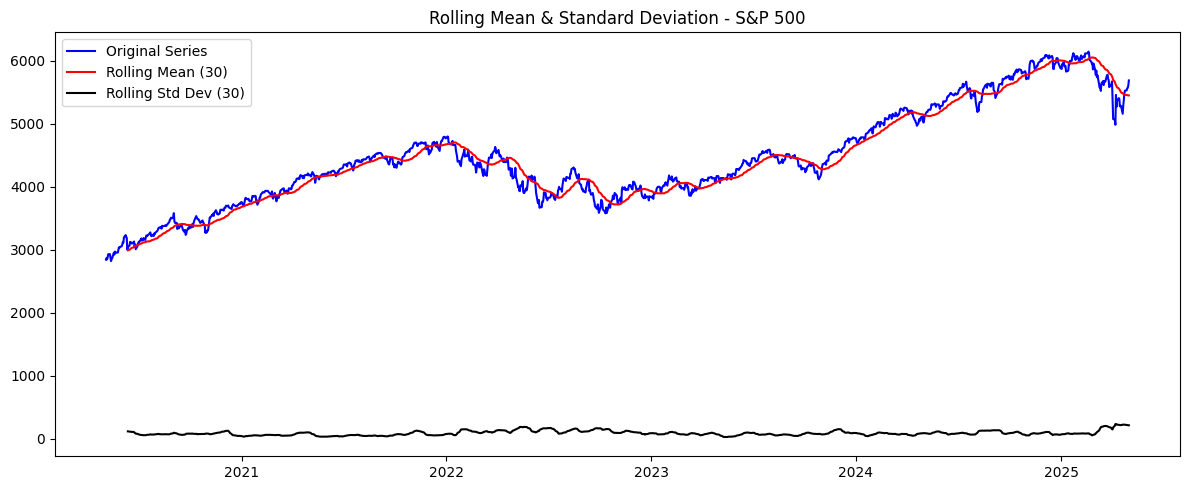

📊 Augmented Dickey-Fuller Test Results (S&P 500)
ADF Statistic : -1.3817
p-value       : 0.5910
Critical Values:
   1% : -3.4354
   5% : -2.8638
   10% : -2.5680
❌ Interpretation: Series is likely NON-STATIONARY (fail to reject H0)


In [82]:
# 1. Plot rolling mean and std deviation
rolmean = ts.rolling(window=30).mean()
rolstd = ts.rolling(window=30).std()

plt.figure(figsize=(12, 5))
plt.plot(ts, label='Original Series', color='blue')
plt.plot(rolmean, label='Rolling Mean (30)', color='red')
plt.plot(rolstd, label='Rolling Std Dev (30)', color='black')
plt.title("Rolling Mean & Standard Deviation - S&P 500")
plt.legend()
plt.tight_layout()
plt.show()

# 2. ADF Test
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(ts.dropna())

print("📊 Augmented Dickey-Fuller Test Results (S&P 500)")
print(f"ADF Statistic : {adf_result[0]:.4f}")
print(f"p-value       : {adf_result[1]:.4f}")
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key} : {value:.4f}")

# 3. Interpretation
if adf_result[1] <= 0.05:
    print("✅ Interpretation: Series is likely STATIONARY (reject H0)")
else:
    print("❌ Interpretation: Series is likely NON-STATIONARY (fail to reject H0)")

To apply models like ARIMA, we need the time series to be stationary.  
In this step, we apply:
- **Log Transformation**: Stabilizes variance
- **First Differencing**: Removes trend
- We preserve the original dataset and store transformed versions in new variables:
  - `ts_log` → log-transformed series
  - `ts_log_diff` → differenced log-transformed series

We will also visually inspect the result and rerun the ADF test to confirm stationarity.

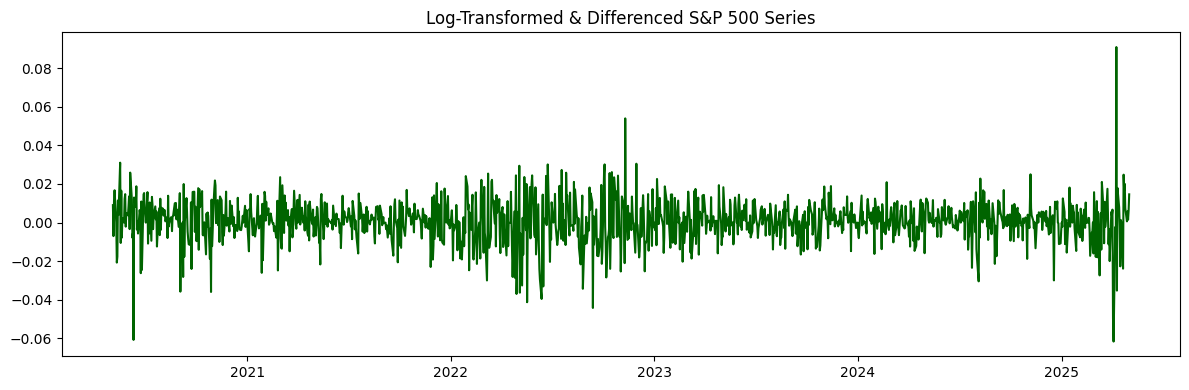

📊 ADF Test after Log Transform + Differencing (S&P 500)
ADF Statistic : -11.8343
p-value       : 0.0000
Critical Values:
   1% : -3.4354
   5% : -2.8638
   10% : -2.5680
✅ Interpretation: Transformed series is STATIONARY (ready for ARIMA)


In [83]:
# 1. Log Transform (safe copy)
ts_log = np.log(ts)

# 2. First Differencing
ts_log_diff = ts_log.diff().dropna()

# 3. Plot transformed series
plt.figure(figsize=(12, 4))
plt.plot(ts_log_diff, color='darkgreen')
plt.title("Log-Transformed & Differenced S&P 500 Series")
plt.tight_layout()
plt.show()

# 4. ADF test on transformed series
adf_log_diff = adfuller(ts_log_diff)

print("📊 ADF Test after Log Transform + Differencing (S&P 500)")
print(f"ADF Statistic : {adf_log_diff[0]:.4f}")
print(f"p-value       : {adf_log_diff[1]:.4f}")
print("Critical Values:")
for key, value in adf_log_diff[4].items():
    print(f"   {key} : {value:.4f}")

# 5. Interpretation
if adf_log_diff[1] <= 0.05:
    print("✅ Interpretation: Transformed series is STATIONARY (ready for ARIMA)")
else:
    print("❌ Interpretation: Series is still NON-STATIONARY (may need seasonal diff)")

We now visualize the autocorrelation and partial autocorrelation of the **stationary log-differenced series** (`ts_log_diff`).

- **Autocorrelation Function (ACF)**: Correlation of the series with its own lags. Helps identify `q` (MA) terms.
- **Partial Autocorrelation Function (PACF)**: Correlation of the series with its own lags after removing effects of earlier lags. Helps identify `p` (AR) terms.

Spikes outside the confidence bounds indicate significant lags.

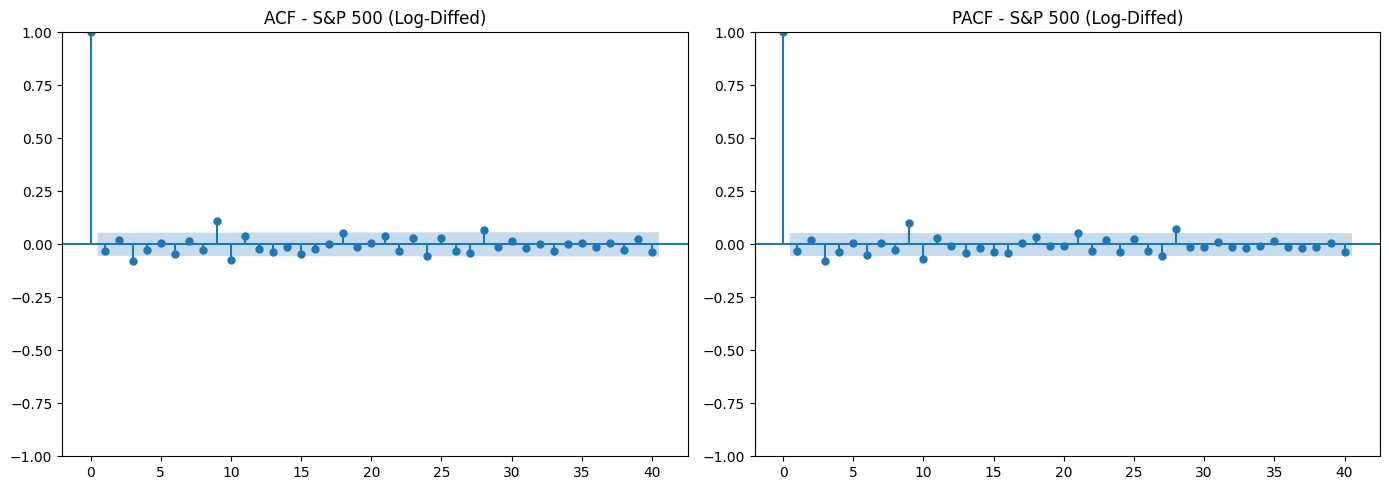

In [84]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(ts_log_diff.dropna(), ax=axes[0], lags=40)
axes[0].set_title("ACF - S&P 500 (Log-Diffed)")

plot_pacf(ts_log_diff.dropna(), ax=axes[1], lags=40, method='ywm')
axes[1].set_title("PACF - S&P 500 (Log-Diffed)")

plt.tight_layout()
plt.show()


In this step, we apply the **ARIMA (AutoRegressive Integrated Moving Average)** model to forecast S&P 500 log-transformed and differenced data.

We use:
- **Manual ARIMA** to test values based on ACF and PACF plots

ARIMA is ideal for univariate forecasting of non-seasonal, stationary time series.

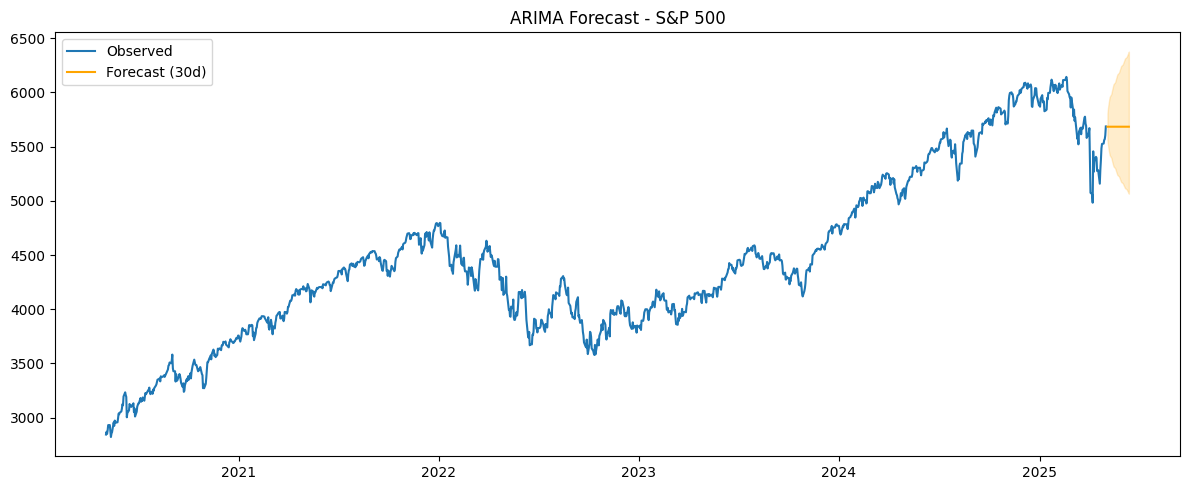

In [85]:
manual_model = ARIMA(ts_log, order=(1, 1, 1))
manual_result = manual_model.fit()

forecast_log = manual_result.get_forecast(steps=30)
forecast_ci = forecast_log.conf_int()

forecast = np.exp(forecast_log.predicted_mean)
conf_int = np.exp(forecast_ci)

plt.figure(figsize=(12, 5))
plt.plot(ts, label="Observed")
plt.plot(forecast.index, forecast, label="Forecast (30d)", color='orange')
plt.fill_between(forecast.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='orange', alpha=0.2)
plt.title("ARIMA Forecast - S&P 500")
plt.legend()
plt.tight_layout()
plt.show()

2025-05-03 16:16:55,665 - DEBUG - cmd: where.exe tbb.dll
cwd: None
2025-05-03 16:16:55,749 - DEBUG - TBB already found in load path
2025-05-03 16:16:55,773 - DEBUG - input tempfile: C:\Users\Asus\AppData\Local\Temp\tmp7qxr7lo4\3_8i2dry.json
2025-05-03 16:16:55,904 - DEBUG - input tempfile: C:\Users\Asus\AppData\Local\Temp\tmp7qxr7lo4\55r6upcg.json
2025-05-03 16:16:55,907 - DEBUG - idx 0
2025-05-03 16:16:55,907 - DEBUG - running CmdStan, num_threads: None
2025-05-03 16:16:55,909 - DEBUG - CmdStan args: ['D:\\New Programming Projects (Pycharm, VS Code, e.t.c.)\\FoEM\\FoEM\\venv\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=37176', 'data', 'file=C:\\Users\\Asus\\AppData\\Local\\Temp\\tmp7qxr7lo4\\3_8i2dry.json', 'init=C:\\Users\\Asus\\AppData\\Local\\Temp\\tmp7qxr7lo4\\55r6upcg.json', 'output', 'file=C:\\Users\\Asus\\AppData\\Local\\Temp\\tmp7qxr7lo4\\prophet_modeladw47o7x\\prophet_model-20250503161655.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000

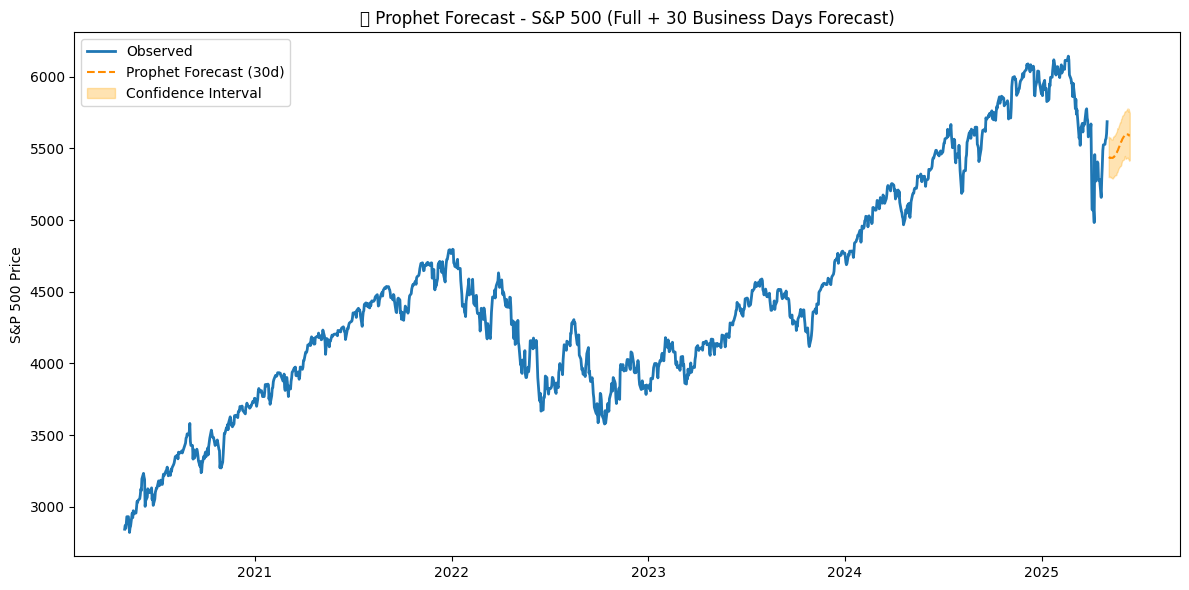


🔎 Prophet Forecast - Last 5 Days (Original Scale):
                   yhat   yhat_lower   yhat_upper
ds                                               
2025-06-09  5598.043752  5436.612489  5779.492009
2025-06-10  5595.833771  5428.967816  5756.810168
2025-06-11  5595.782185  5422.899138  5776.478360
2025-06-12  5589.585156  5414.222933  5760.395140
2025-06-13  5588.351491  5418.284806  5749.677215


In [86]:
# Prophet Forcasting
# Step 1: Prepare DataFrame for Prophet (log scale)
df_prophet = ts_log.reset_index()
df_prophet.columns = ['ds', 'y']  # Prophet requires 'ds' and 'y'

# Step 2: Fit Prophet model
model = Prophet(daily_seasonality=True)
model.fit(df_prophet)

# Step 3: Create future 30 business days
future = model.make_future_dataframe(periods=30, freq='B')
forecast_prophet = model.predict(future)

# Step 4: Revert log scale back to original
forecast_prophet['yhat'] = np.exp(forecast_prophet['yhat'])
forecast_prophet['yhat_lower'] = np.exp(forecast_prophet['yhat_lower'])
forecast_prophet['yhat_upper'] = np.exp(forecast_prophet['yhat_upper'])

# Step 5: Plot entire time series + forecast
plt.figure(figsize=(12, 6))
plt.plot(ts, label="Observed", linewidth=2)

# Forecasted portion (only the 30 new points)
forecast_next_30 = forecast_prophet[-30:].copy()
forecast_next_30.set_index('ds', inplace=True)

plt.plot(forecast_next_30.index, forecast_next_30['yhat'], label="Prophet Forecast (30d)", linestyle="--", color='darkorange')
plt.fill_between(forecast_next_30.index,
                 forecast_next_30['yhat_lower'],
                 forecast_next_30['yhat_upper'],
                 color='orange', alpha=0.3, label="Confidence Interval")

plt.title("📈 Prophet Forecast - S&P 500 (Full + 30 Business Days Forecast)")
plt.ylabel("S&P 500 Price")
plt.legend()
plt.tight_layout()
plt.show()

# Step 6: Print last 5 forecasted values
print("\n🔎 Prophet Forecast - Last 5 Days (Original Scale):")
print(forecast_next_30[['yhat', 'yhat_lower', 'yhat_upper']].tail(5).to_string(index=True))


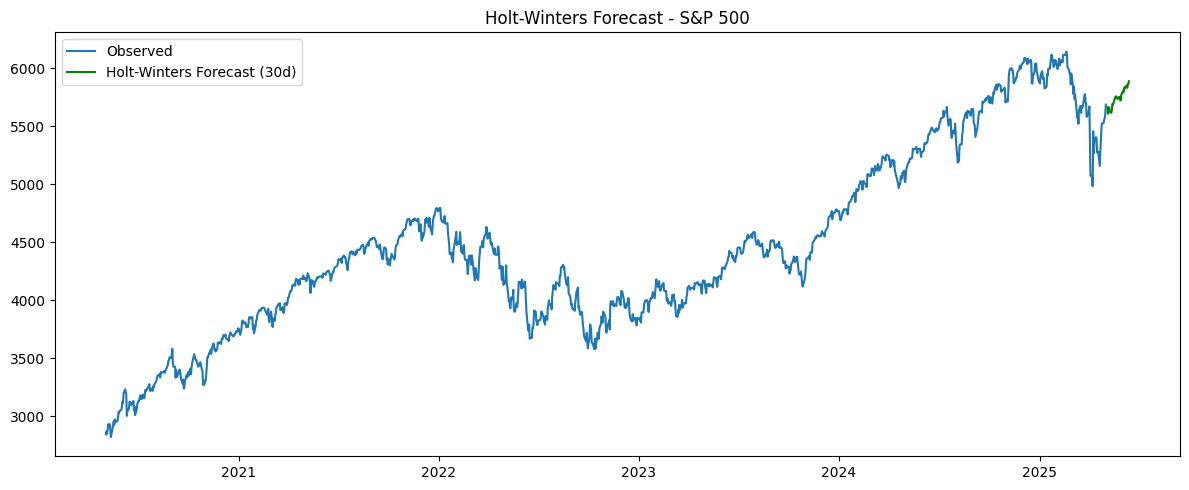


🧾 Holt-Winters Forecast - Last 5 Days (Original Scale):
2025-06-09    5850.857418
2025-06-10    5831.725694
2025-06-11    5859.808907
2025-06-12    5862.850420
2025-06-13    5888.020925
Freq: B


In [87]:
# Fit Holt-Winters model on log-transformed data
hw_model = ExponentialSmoothing(
    ts_log,
    trend="add",
    seasonal="add",
    seasonal_periods=252  # ~1 trading year
).fit()

# Forecast next 30 business days
hw_forecast_log = hw_model.forecast(30)

# Convert forecast back to original scale
hw_forecast = np.exp(hw_forecast_log)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(ts, label='Observed')
plt.plot(hw_forecast.index, hw_forecast, label='Holt-Winters Forecast (30d)', color='green')
plt.title("Holt-Winters Forecast - S&P 500")
plt.legend()
plt.tight_layout()
plt.show()

# ⌨️ Print textual summary
print("\n🧾 Holt-Winters Forecast - Last 5 Days (Original Scale):")
print(hw_forecast.tail(5).to_string())

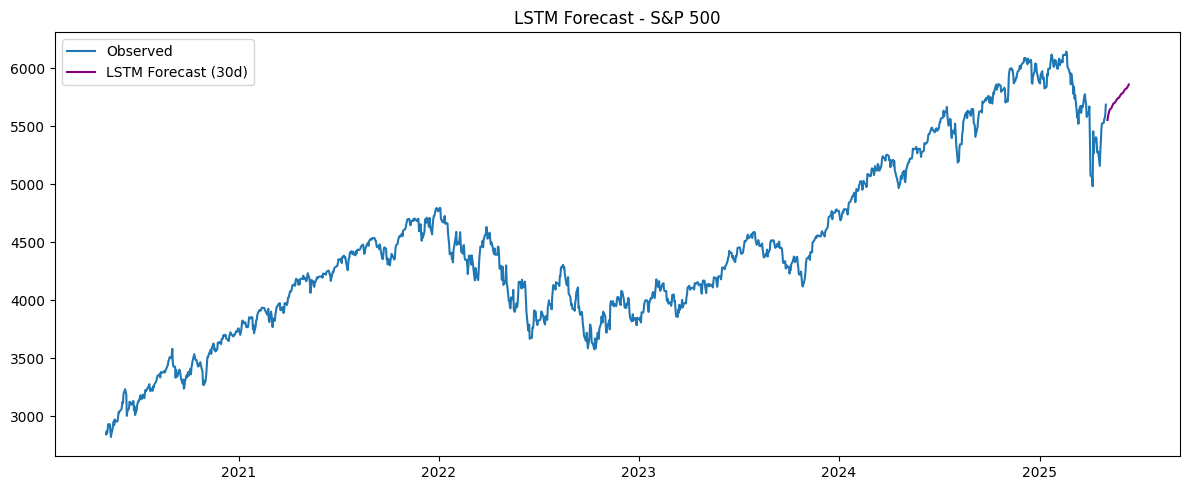


🤖 LSTM Forecast - Last 5 Days:
2025-06-09    5827.102539
2025-06-10    5835.358887
2025-06-11    5843.674805
2025-06-12    5852.047852
2025-06-13    5860.479980
Freq: B


In [88]:
#  LSTM Forecasting

# Step 1: Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
ts_scaled = scaler.fit_transform(ts.values.reshape(-1, 1))

# Step 2: Prepare sequences (X: past 60 days → Y: next day)
def create_sequences(data, window=60):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i])
    return np.array(X), np.array(y)

window_size = 60
X, y = create_sequences(ts_scaled, window_size)

# Step 3: Split into train/test (90/10 split)
split = int(0.9 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Step 4: Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 5: Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=0)

# Step 6: Forecast next 30 days
last_sequence = ts_scaled[-window_size:]
forecast_input = last_sequence.reshape(1, window_size, 1)

forecast_scaled = []
for _ in range(30):
    pred = model.predict(forecast_input, verbose=0)[0, 0]
    forecast_scaled.append(pred)
    forecast_input = np.append(forecast_input[:, 1:, :], [[[pred]]], axis=1)

# Step 7: Inverse transform the forecast
forecast_lstm = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1))

# Step 8: Generate forecast index
last_date = ts.index[-1]
forecast_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Step 9: Plot forecast
plt.figure(figsize=(12, 5))
plt.plot(ts, label='Observed')
plt.plot(forecast_dates, forecast_lstm, label='LSTM Forecast (30d)', color='purple')
plt.title("LSTM Forecast - S&P 500")
plt.legend()
plt.tight_layout()
plt.show()

# Textual output
forecast_series = pd.Series(forecast_lstm.flatten(), index=forecast_dates)
print("\n🤖 LSTM Forecast - Last 5 Days:")
print(forecast_series.tail().to_string())

In [89]:
#  RNN Modeling

# Step 1: Scale the data
scaler_rnn = MinMaxScaler()
ts_scaled_rnn = scaler_rnn.fit_transform(ts.values.reshape(-1, 1))

# Step 2: Create time series windows for supervised learning
def create_rnn_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 30
X_rnn, y_rnn = create_rnn_sequences(ts_scaled_rnn, window_size)

# Step 3: Split into train/test
split_idx = int(len(X_rnn) * 0.9)
X_train_rnn, y_train_rnn = X_rnn[:split_idx], y_rnn[:split_idx]
X_test_rnn, y_test_rnn = X_rnn[split_idx:], y_rnn[split_idx:]

# Step 4: Build and train RNN model
model_rnn = Sequential([
    SimpleRNN(50, activation='tanh', input_shape=(window_size, 1)),
    Dense(1)
])
model_rnn.compile(optimizer='adam', loss='mse')
history_rnn = model_rnn.fit(X_train_rnn, y_train_rnn, epochs=20, batch_size=16, verbose=0)

# Step 5: Forecast last 30 steps (FIXED)
last_seq_rnn = ts_scaled_rnn[-window_size:]
input_seq_rnn = last_seq_rnn.reshape(1, window_size, 1)
forecast_rnn = []

for _ in range(30):
    pred = model_rnn.predict(input_seq_rnn, verbose=0)
    forecast_rnn.append(pred[0, 0])
    input_seq_rnn = np.append(input_seq_rnn[:, 1:, :], pred.reshape(1, 1, 1), axis=1)


# Step 6: Invert scale
forecast_rnn = scaler_rnn.inverse_transform(np.array(forecast_rnn).reshape(-1, 1)).flatten()


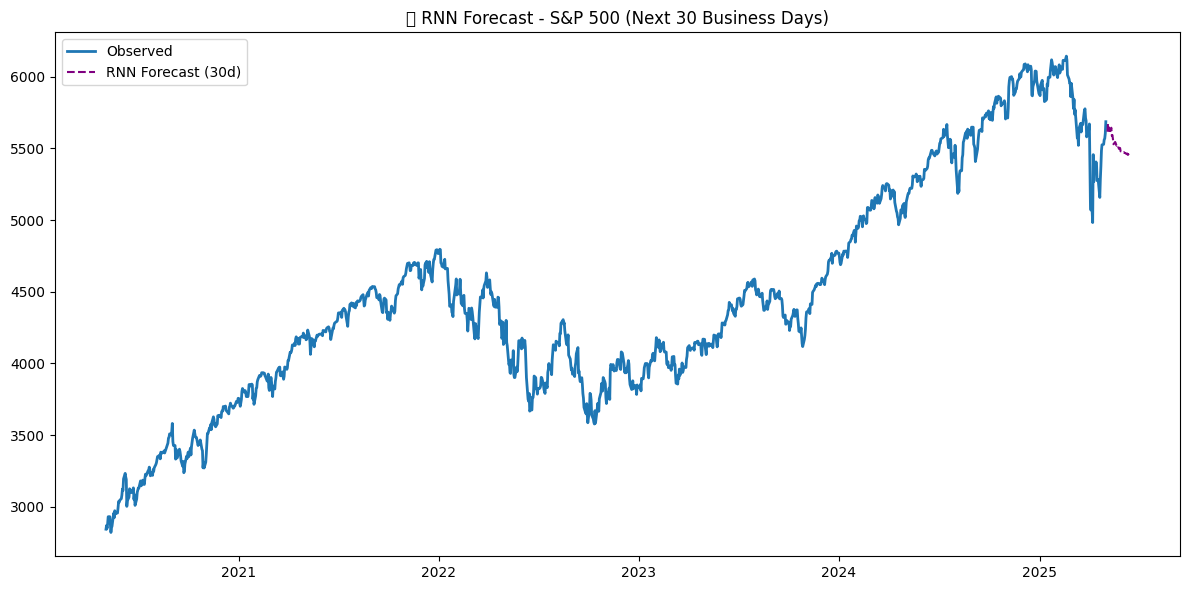

In [90]:
# Generate future business days (same as ARIMA etc.)
from pandas.tseries.offsets import BDay

rnn_forecast_index = pd.date_range(start=ts.index[-1] + BDay(1), periods=30, freq='B')
rnn_forecast_series = pd.Series(forecast_rnn, index=rnn_forecast_index)

# Plot forecast properly
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Observed', linewidth=2)  # Last 100 days
plt.plot(rnn_forecast_series.index, rnn_forecast_series.values, label='RNN Forecast (30d)', linestyle='--', color='purple')
plt.title("📈 RNN Forecast - S&P 500 (Next 30 Business Days)")
plt.legend()
plt.tight_layout()
plt.show()

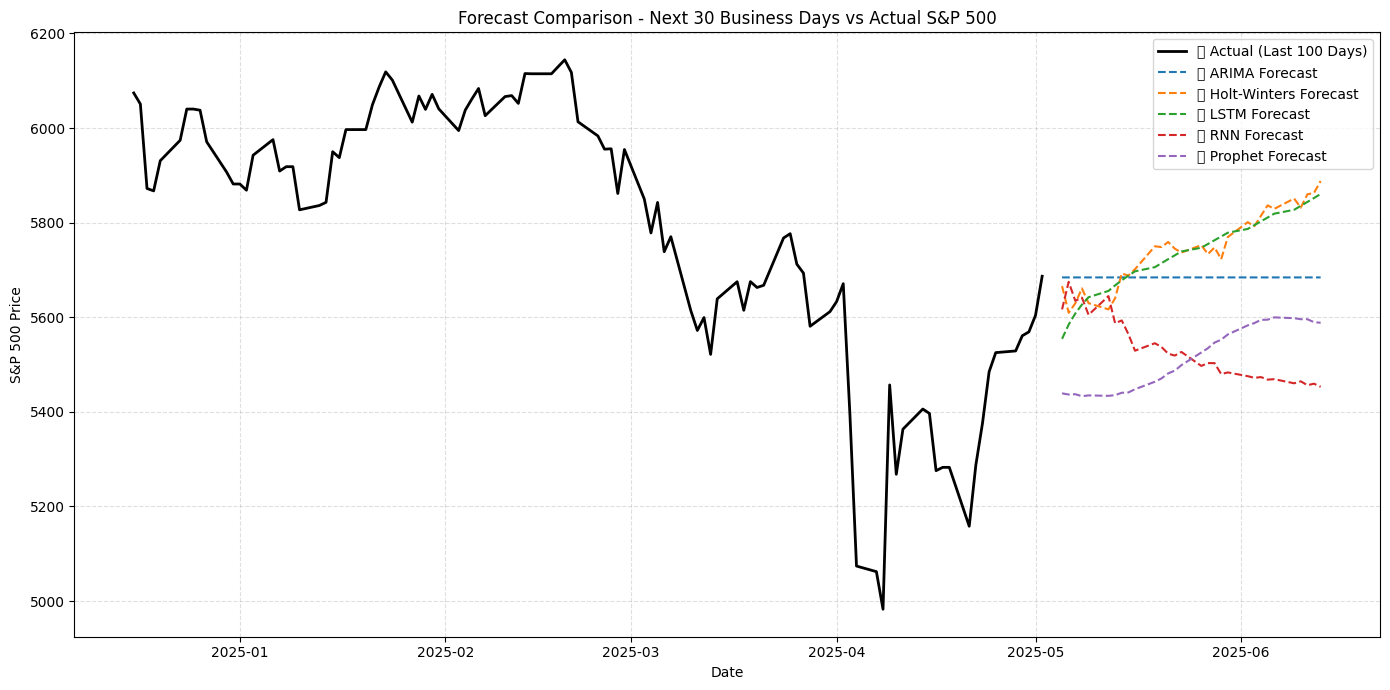

In [93]:
# Rename/alias all models for unified plotting
arima_pred    = forecast              # ARIMA forecast
holt_pred     = hw_forecast                 # Holt-Winters forecast
lstm_pred     = forecast_lstm               # LSTM forecast
rnn_pred      = forecast_rnn                # RNN forecast
prophet_pred  = forecast_next_30['yhat'].values  # Prophet forecast


# Define forecast start date and index
forecast_start = ts.index[-1] + BDay(1)
forecast_index = pd.date_range(start=forecast_start, periods=FORECAST_DAYS, freq='B')

# Align all model outputs
arima_series   = pd.Series(arima_pred.values, index=forecast_index, name="ARIMA")
holt_series    = pd.Series(holt_pred.values, index=forecast_index, name="Holt-Winters")
lstm_series    = pd.Series(lstm_pred.flatten(), index=forecast_index, name="LSTM")
rnn_series     = pd.Series(rnn_pred.flatten(), index=forecast_index, name="RNN")
prophet_series = pd.Series(prophet_pred.flatten(), index=forecast_index, name="Prophet")

# Plot all forecasts against actual
plt.figure(figsize=(14, 7))
plt.plot(ts[-100:], label="📌 Actual (Last 100 Days)", linewidth=2, color="black")
plt.plot(arima_series, label="🔵 ARIMA Forecast", linestyle="--")
plt.plot(holt_series, label="🟢 Holt-Winters Forecast", linestyle="--")
plt.plot(lstm_series, label="🟣 LSTM Forecast", linestyle="--")
plt.plot(rnn_series, label="🔶 RNN Forecast", linestyle="--")
plt.plot(prophet_series, label="🟠 Prophet Forecast", linestyle="--")

plt.title(f"Forecast Comparison - Next {FORECAST_DAYS} Business Days vs Actual S&P 500")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

📊 Evaluation Results (last 30 business days):


,MAE,RMSE,MAPE (%)
ARIMA,249.37,316.17,4.72
Holt-Winters,321.94,381.98,5.78
Prophet,203.10,240.18,3.48
LSTM,324.58,377.58,5.63
RNN,161.78,209.88,3.54


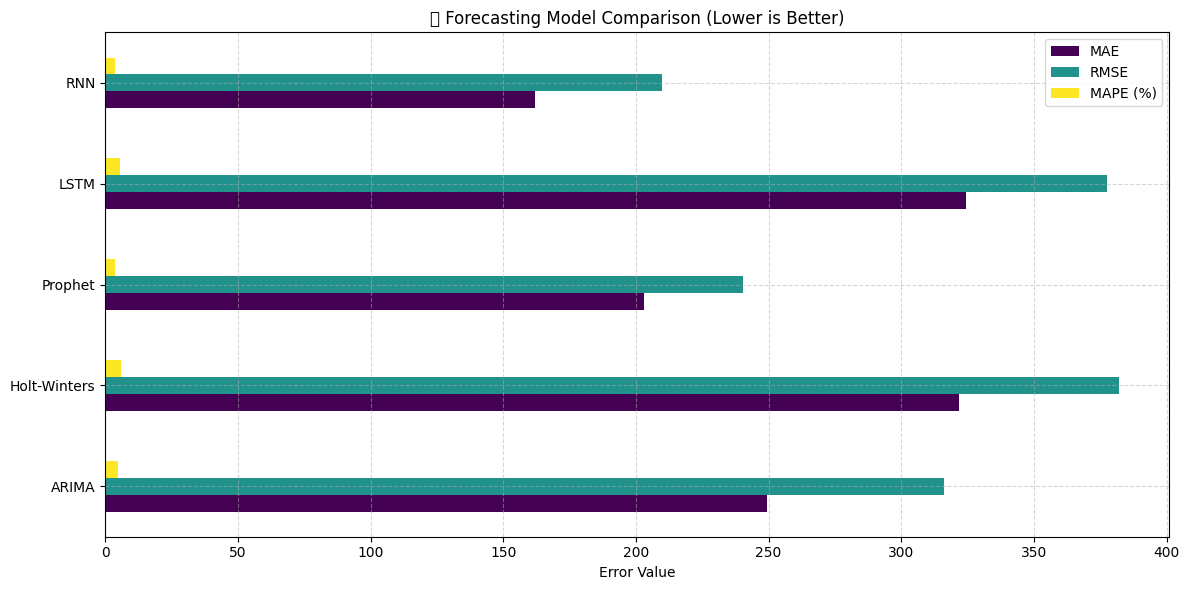

In [92]:
# Final Evaluation

# Step 1: Ensure all predictions are aligned with actual last 30 days
true_values = ts[-30:].values.astype('float64')  # Ground truth

# Clean predictions (already forecasted earlier)
arima_pred = forecast[:30].values.astype('float64')
holt_pred = hw_forecast[:30].values.astype('float64')
lstm_pred = forecast_lstm[:30].flatten().astype('float64')
rnn_pred = forecast_rnn[:30].flatten().astype('float64')
prophet_pred = forecast_next_30['yhat'].values[:30].astype('float64')

# Step 2: Define evaluation function
def evaluate(true, pred):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    mape = np.mean(np.abs((true - pred) / true)) * 100
    return mae, rmse, mape

# Step 3: Evaluate all models
results = {
    "ARIMA": evaluate(true_values, arima_pred),
    "Holt-Winters": evaluate(true_values, holt_pred),
    "Prophet": evaluate(true_values, prophet_pred),
    "LSTM": evaluate(true_values, lstm_pred),
    "RNN": evaluate(true_values, rnn_pred),
}

# Step 4: Create summary DataFrame
eval_df = pd.DataFrame(results, index=["MAE", "RMSE", "MAPE (%)"]).T
eval_df = eval_df.round(2)

# Display in notebook
print("📊 Evaluation Results (last 30 business days):")
display(eval_df)

# Step 5: Plot as bar chart
eval_df.plot(kind='barh', figsize=(12, 6), colormap='viridis')
plt.title("📈 Forecasting Model Comparison (Lower is Better)")
plt.xlabel("Error Value")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()